In [1]:
# We import required libraries and set some preferences

import numpy as np
import pandas as pd
import random

%matplotlib inline
import matplotlib.pylab as pl

import matplotlib
font = {'weight' : '200',
        'size'   : 14}

matplotlib.rc('font', **font)

In [2]:
# We import the dataset

filename = "../datasets/absenteeism_at_work.csv"
df = pd.read_csv(filename, sep=';')

In [3]:
# We define a simple data schema for the data.
# This helps Dwork to estimate the required amount of noise that we need
# to add in order to achieve a given privacy guarantee.
from dwork.dataschema import DataSchema
from dwork.language.types import Integer, Float

class AbsenteeismSchema(DataSchema):

    """
    We only define attributes that we really want to use in our example.
    """

    Weight = Integer(min=0, max=200)
    Height = Integer(min=0, max=200)
    Absenteeism_time_in_hours = Integer(min=0, max=100)
    
    names = {
        'Absenteeism_time_in_hours' : 'Absenteeism time in hours'
    }

In [4]:
# We create a Dwork dataset from it

from dwork.dataset.pandas import PandasDataset
ds = PandasDataset(AbsenteeismSchema, df)

In [5]:
# Now, the first thing we do is to calculate a simple sum.
# This is not very useful in practice but demonstrates how
# Dwork automates the calculation of the sensitivity.

# we add two values together (which is nonsensical in this case)
x = (ds["Weight"]+ds["Height"]).sum()
assert not x.is_dp()

tx = (ds.df["Weight"]+ds.df["Height"]).sum()
# we make sure the exact value is what we expect
assert tx == 185851

# we make sure the exact value is identical to the expression value
assert tx == x.true()

# we make sure the 
assert 183000 <= x.dp(0.5) <= 189000

uniques = set()
for i in range(10):
    xdp = x.dp(0.5)
    uniques.add(xdp)
    assert 183000 <= xdp <= 189000

# we check that the DP mechanism does not always produce the same value
# (this is not a proper DP test)
# assert len(uniques) >= 3

In [6]:
# Now, we can also calculate more complex (and useful) expressions,
# for example the mean weight of all people in the dataset.

x = ds["Weight"].sum()/ds.len()
assert not x.is_dp()

tx = ds.df["Weight"].sum()/len(ds.df)
# we make sure the exact value is what we expect
assert tx == 79.03513513513514

# we make sure the exact value is identical to the expression value
assert tx == x.true()

n = len(ds.df)
s = ds.df["Weight"].sum()
# Dwork overestimates the sensitivity here because it cannot know that
# the length of the array will never decrease when the sum increases.
# It just knows that the dividend has a sensitivity of 200 and the
# divisor has a sensitivity of 1. The true sensitivity of this
# expression is given as 0.27
ts = (s+200)/(n-1)-s/n

# we make sure the sensitivity is lower than that of the original value
assert x.sensitivity() == ts

uniques = set()
for i in range(10):
    xdp = x.dp(0.5)
    uniques.add(xdp)
    assert 60 <= xdp <= 100

# we check that the DP mechanism does not always produce the same value
# (this is not a proper DP test)
assert len(uniques) >= 3

# Aggregate Statistics

Often, when analyzing a given dataset we're interested in specific statistical quantities like e.g. the mean of a given attribute or the distribution of values for a given attribute or attribute combination. We can caculate all these quantities in a differentially private mannner using Dwork. To do this, we can make use of Dworks' "group by" functionality, which will produce groups of datapoints based on a set of criteria we define. For each of these groups we can then calculate statistical quantities like the sum or mean value of an attribute, or the number of datapoints in that given Group. Dwork will make the results of the given expressions / quantities differentially private by first calculating the sensitivity of the given expression in respect to a  single datapoint and then, based on this sensitivity and the type of the expression, adding a sufficient amount of noise to achieve a given $\epsilon$ value. Please note taht this $\epsilon$ value only applies to that single expression. Often, we are interested the overall $\epsilon$ of all the expressions that we calculate, since this value provides an upper bound for the privacy loss of an individual. Even defining this privacy loss is not easy in many cases, as there are different risk and attack models that we can use to quantify the privacy risk of an individual. Typically, we consider two distinct risks: The so-called re-identification risk, and the inference risk. Re-identification means that an adversary is able to asser that the data of a given individual was contained in either the entire dataset or a subgroup of the dataset. Inference risk means that an adversary, who might assume or know that the data of a given individual is part of a dataset or group of datapoints, is able to infer the value of a single or multiple attributes of that individual based on the data. Which of these risks is more severe strongly depends on the context and the specific data being analyzed. In some cases, re-identifying an individual in a dataset, or equivalently, asserting that the data of an individual is part of a dataset, can already pose a risk to that individual. For example, learning that a persons' data is contained in a dataset that describes individuals suffering from a serious health condition might have a negative impact on the life of that individual. Similarly, an individual might suffer negative consequences if values or value ranges of individual attributes can be inferred by an adversary. For example, learning or (accurately) estimating the salary of an individual from a dataset of "anonymous" wage data might lead to social pressure or mobbing of that individual within an organization.

When calculating statistics for a large number of datapoints, the overall $\epsilon$ for a given datapoint will often strongly depend on the specific attribute values of that datapoint, as those values determine in which groups the datapoint appears, which in turn determines which expressions are calculated using attribute on the datapoint. In addition, the sensitivity of an expression in respect to a specific datapoint might not be constant. For example, when calculating the minimum value of a range of datapoints, the smallest datapoints will often have a higher sensitivity in respect to the calculated minimum value than the largest datapoints. Hence, even when calculating a single DP expression the given $\epsilon$ is a worst-case value and might drastically overestimate the actual $\epsilon$ value of a specific datapoint, and thus individual.

As an example, we will first calculate several descriptive statistics (in particular histograms) on the original data, and then use Dwork to produce differentially private versions of these statistics. 

In [7]:
# we have a look at the dataset
df

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,...,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26,7,3,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239.554,...,1,1,1,1,0,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239.554,...,0,1,0,1,0,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239.554,...,0,1,2,1,1,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,11,14,7,3,1,289,36,13,33,264.604,...,0,1,2,1,0,1,90,172,30,8
736,1,11,7,3,1,235,11,14,37,264.604,...,0,3,1,0,0,1,88,172,29,4
737,4,0,0,3,1,118,14,13,40,271.219,...,0,1,1,1,0,8,98,170,34,0
738,8,0,0,4,2,231,35,14,39,271.219,...,0,1,2,1,0,2,100,170,35,0


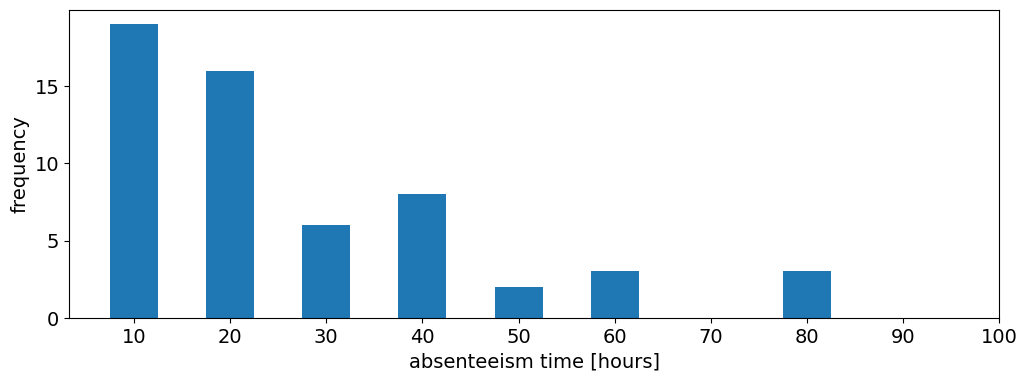

In [8]:
# we plot the histogram of the absenteeism time in hours (omitting the zero value)
pl.figure(figsize=(12,4))
bins = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
pl.hist(df["Absenteeism time in hours"], bins=bins, rwidth=0.5, align='left')
pl.xlabel("absenteeism time [hours]")
pl.ylabel("frequency")
pl.xticks(bins);
pl.savefig("absenteeism-true.pdf")

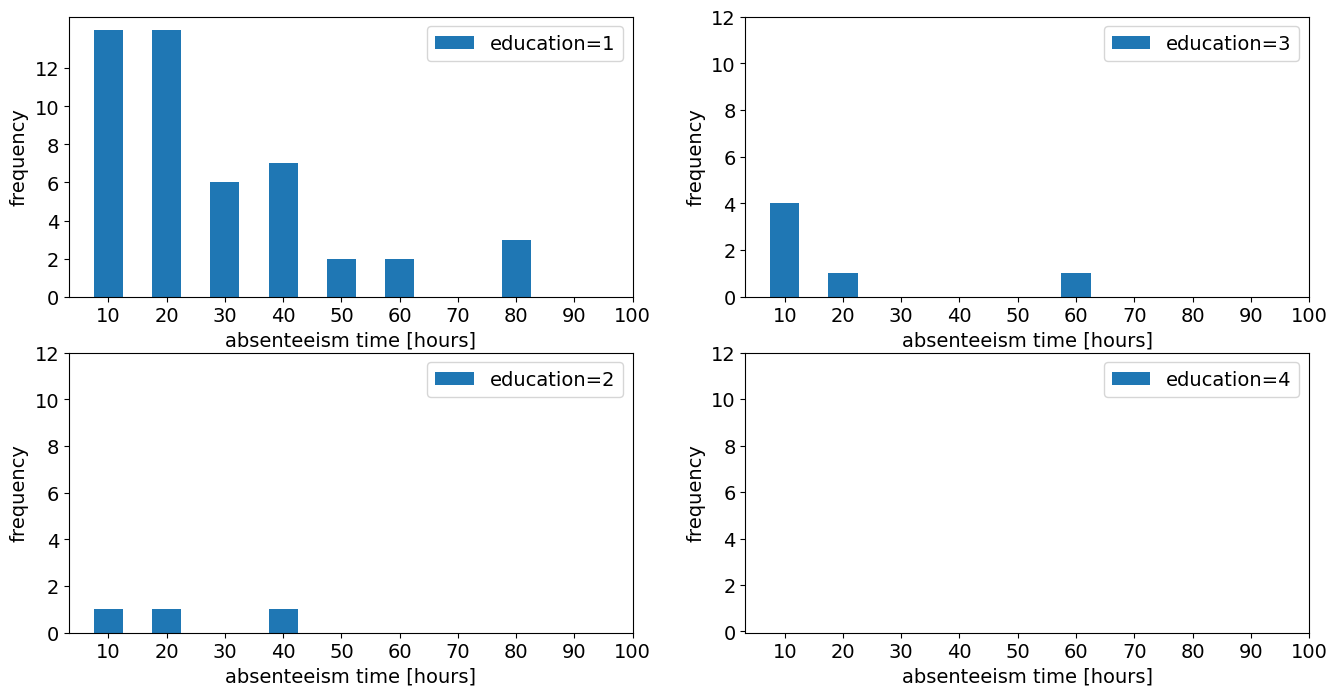

In [9]:
# now we plot the conditional frequencies for different values of the "Education" attribute.
pl.figure(figsize=(16,8))
for i, edu in enumerate(df["Education"].unique()):
    pl.subplot(2, 2, i+1)
    dff = df[df["Education"] == edu]
    pl.hist(dff["Absenteeism time in hours"], bins=bins, rwidth=0.5, align='left')
    pl.xlabel("absenteeism time [hours]")
    pl.ylabel("frequency")
    pl.xticks(bins)
    pl.yticks([0, 2, 4, 6, 8, 10, 12])
    pl.legend([f"education={edu}"])
    #pl.semilogy()
pl.savefig("absenteeism-vs-education-true.pdf")

In [12]:
# Now we calculate the frequencies for a combination of the "Age" and "Service times" attributes.
# We do this by manually filtering the dataset and grouping it by the two properties.
# (we could also have equally well used Pandas' `.groupby()` function for this)
ages = [25, 30, 35, 40, 45, 50, 55]
service_times = [0, 5, 10, 15, 20, 25]
m = np.zeros((len(ages), len(service_times)), dtype=np.int16)
for i, age in enumerate(ages):
    for j, service_time in enumerate(service_times):
        dff = df[(df["Age"] >= age) & (df["Age"] < age+5) & (df["Service time"] >= service_time) & (df["Service time"] < service_time+5)]
        v = dff["Absenteeism time in hours"].mean()
        if len(dff) == 0:
            v = 0
        print(age, service_time, v)
        m[i,j] = v

25 0 7.6
25 5 4.450549450549451
25 10 0
25 15 0
25 20 0
25 25 0
30 0 4.857142857142857
30 5 5.271186440677966
30 10 12.494736842105263
30 15 0
30 20 0
30 25 0
35 0 0
35 5 0
35 10 6.1838235294117645
35 15 4.265486725663717
35 20 0
35 25 0
40 0 0
40 5 0
40 10 7.096774193548387
40 15 7.425925925925926
40 20 0
40 25 0
45 0 0
45 5 0
45 10 3.2666666666666666
45 15 0
45 20 8.0
45 25 3.2
50 0 0
50 5 5.333333333333333
50 10 0.0
50 15 9.147058823529411
50 20 0
50 25 0
55 0 0
55 5 0
55 10 0
55 15 32.75
55 20 0
55 25 0


/tmp/ipykernel_68946/3001622430.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+ages)
/tmp/ipykernel_68946/3001622430.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+service_times)


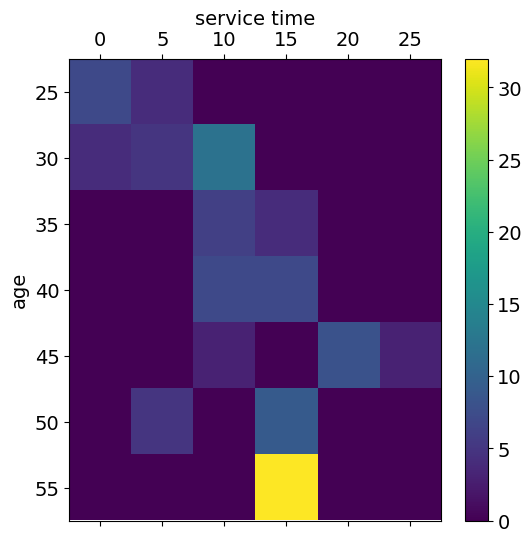

In [13]:
# we plot the frequencies as a matrix plot
pl.figure(figsize=(6,6))
ax = pl.subplot(111)
cax = ax.matshow(m, aspect='auto')
ax.set_yticklabels(['']+ages)
ax.set_xticklabels(['']+service_times)
ax.set_xlabel('service time')
ax.xaxis.set_label_position('top') 
pl.ylabel("age")
pl.colorbar(cax)
pl.savefig("absenteeism-service-time-age-true.pdf")

In [14]:
time_bins = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
# we always exclude the right value, as this is also done in the histograms above
df["Age-bins"] = pd.cut(df["Age"], bins=ages+[60], right=False)
df["Service time-bins"] = pd.cut(df["Service time"], bins=service_times+[30], include_lowest=True, right=False)
df["Absenteeism time-bins"] = pd.cut(df["Absenteeism time in hours"], bins=time_bins, include_lowest=True, right=False)

In [19]:
# we re-initialize the Dwork dataset with the new binned values
ds = PandasDataset(AbsenteeismSchema, df)

In [20]:
# we group by education
ds_by_time = ds.group_by(by=["Absenteeism time-bins"])

/home/parallels/projects/geordi/kiprotect/dwork/dwork/dataset/pandas.py:203: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for key, group in dataset.df.groupby(**kwargs):


In [23]:
epsilon = 0.5
dp_bins = []
dp_frequencies = []
for (group,), dataset in zip(ds_by_time.groups, ds_by_time.datasets):
    dp_bins.append(group.left)
    dp_frequencies.append(dataset.len().dp(epsilon=epsilon))

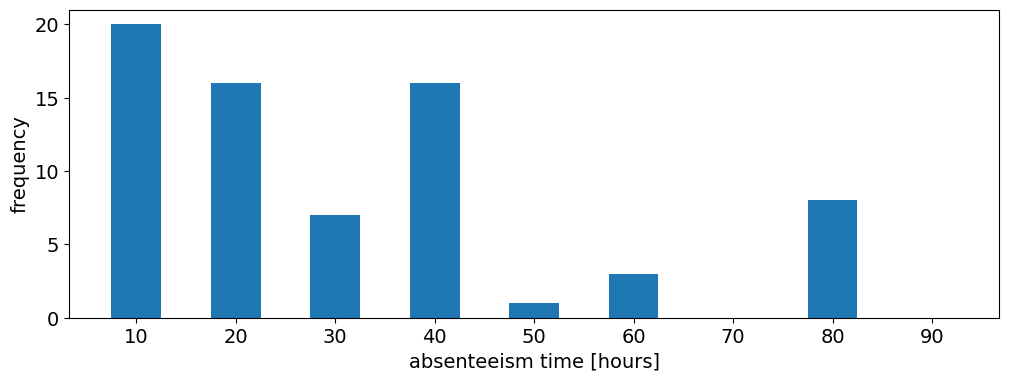

In [24]:
pl.figure(figsize=(12,4))
pl.bar(dp_bins, dp_frequencies, width=5)
pl.xlabel("absenteeism time [hours]")
pl.ylabel("frequency")
pl.xticks(dp_bins);
pl.savefig("absenteeism-dp.pdf");

In [25]:
# we group by education
ds_by_education = ds.group_by(by=["Education"])

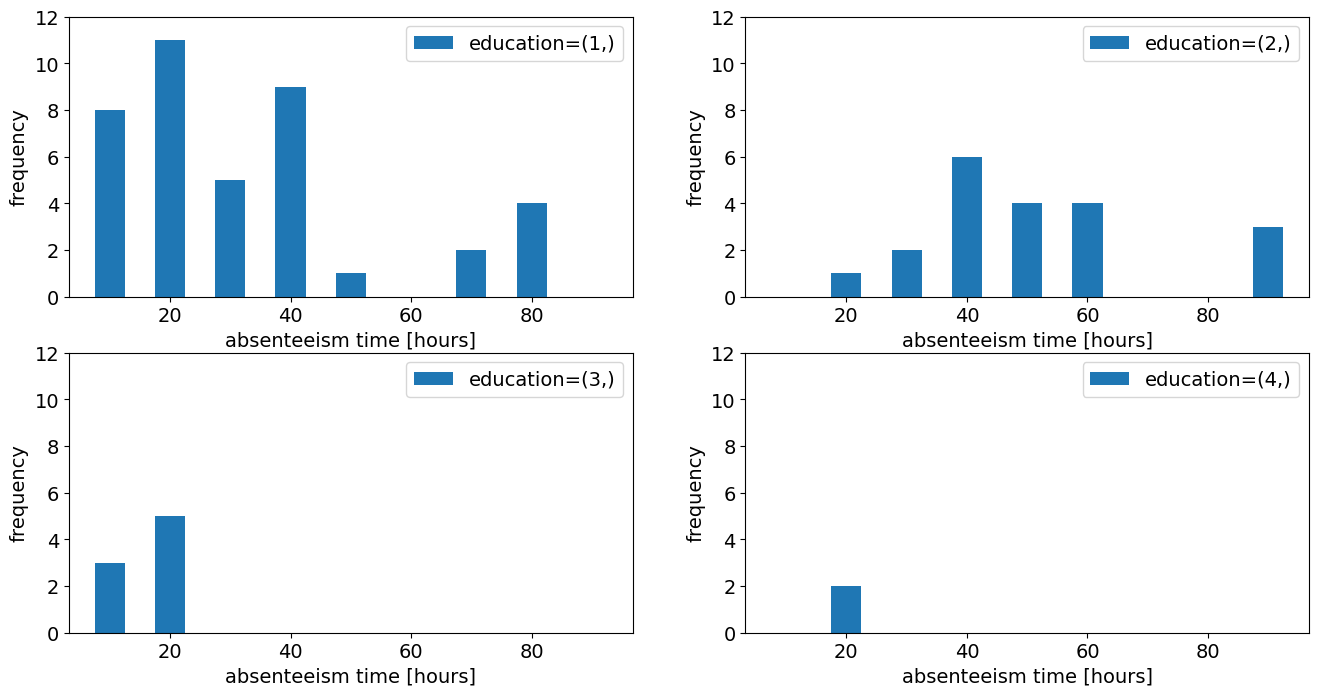

In [27]:
pl.figure(figsize=(16,8))

# we first iterate through the data that was grouped by education
for i, (group, dataset) in enumerate(zip(ds_by_education.groups, ds_by_education.datasets)):
    pl.subplot(2, 2, i+1)

    # we then group by absenteeism time, as before
    dsg_by_time = dataset.group_by(by=["Absenteeism time-bins"])

    # and we manually calculate a histogram again
    dp_bins = []
    dp_frequencies = []
    for (sub_group,), sub_dataset in zip(dsg_by_time.groups, dsg_by_time.datasets):
        dp_bins.append(sub_group.left)
        dp_frequencies.append(sub_dataset.len().dp(epsilon=epsilon))
    
    pl.bar(dp_bins, dp_frequencies, width=5)
    
    pl.xlabel("absenteeism time [hours]")
    pl.legend([f"education={group}"])
    pl.yticks([0, 2, 4, 6, 8, 10, 12])
    pl.ylabel("frequency")
pl.savefig("absenteeism-vs-education-dp.pdf")

In [33]:
# Now we calculate the frequencies for a combination of the "Age" and "Service times" attributes.
# We do this by manually filtering the dataset and grouping it by the two properties.
# (we could also have equally well used Pandas' `.groupby()` function for this)
mdp = np.zeros((len(ages), len(service_times)), dtype=np.int16)

dsg = ds.group_by(by=["Service time-bins", "Age-bins"])

for group, dataset in zip(dsg.groups, dsg.datasets):
    iy = service_times.index(group[0].left)
    ix = ages.index(group[1].left)
    at = dataset["Absenteeism time in hours"]
    n = at.len().dp(epsilon=0.5)
    s = at.sum().dp(epsilon=0.5)
    if n < 5:
        v = 0
    else:
        v = s/n
    if not 0 < v < 100:
        v = 0
    mdp[ix,iy] = v

/tmp/ipykernel_68946/757739273.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+ages)
/tmp/ipykernel_68946/757739273.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+service_times)


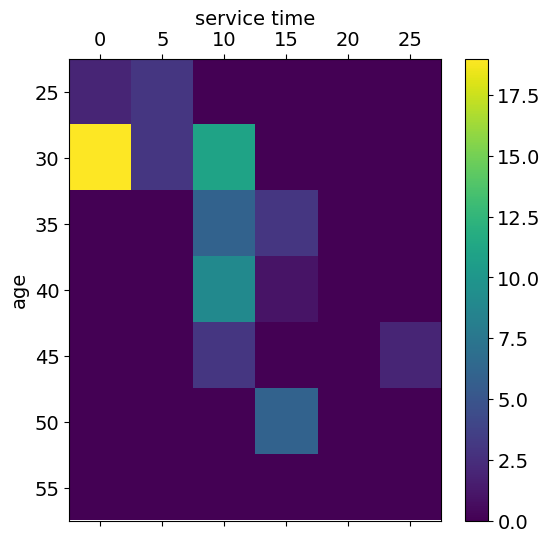

In [39]:
# we plot the frequencies as a matrix plot
pl.figure(figsize=(6,6))
ax = pl.subplot(111)
cax = ax.matshow(mdp, aspect='auto')
ax.set_yticklabels(['']+ages)
ax.set_xticklabels(['']+service_times)
ax.set_xlabel('service time')
ax.xaxis.set_label_position('top') 
pl.ylabel("age")
pl.colorbar(cax)
pl.savefig("absenteeism-service-time-age-dp.pdf")

In [40]:
m

array([[ 7,  4,  0,  0,  0,  0],
       [ 4,  5, 12,  0,  0,  0],
       [ 0,  0,  6,  4,  0,  0],
       [ 0,  0,  7,  7,  0,  0],
       [ 0,  0,  3,  0,  8,  3],
       [ 0,  5,  0,  9,  0,  0],
       [ 0,  0,  0, 32,  0,  0]], dtype=int16)

In [41]:
mdp

array([[ 2,  3,  0,  0,  0,  0],
       [19,  3, 11,  0,  0,  0],
       [ 0,  0,  6,  3,  0,  0],
       [ 0,  0,  9,  1,  0,  0],
       [ 0,  0,  3,  0,  0,  2],
       [ 0,  0,  0,  6,  0,  0],
       [ 0,  0,  0,  0,  0,  0]], dtype=int16)

In [42]:
df["Age-bins"].unique()

[[30, 35), [50, 55), [35, 40), [25, 30), [40, 45), [45, 50), [55, 60)]
Categories (7, interval[int64, left]): [[25, 30) < [30, 35) < [35, 40) < [40, 45) < [45, 50) < [50, 55) < [55, 60)]